In [1]:
%load_ext autoreload
%autoreload 2

In [396]:
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph
import copy

In [391]:
def build_random_graph(n_nodes=10):
    nodes = []
    name = 'a'
    for _ in range(n_nodes):
        args = [nodes[i] for i in range(0 if len(nodes) == 0 else np.random.choice(len(nodes)))]
        node = Node(name, lambda *args: int(sum(args) >= len(args)), args) # and function
        # node = Node(name, lambda *args: int(sum(args) >= 1), args) # or function
        name = chr(ord(name) + 1)
        nodes.append(node)

    print(len(nodes), "nodes")
    source_nodes = get_source_nodes(nodes)
    n_relevant_features = np.random.choice(range(1, len(nodes)))
    feature_mask = np.random.choice(range(1, len(nodes)), n_relevant_features, replace=False)
    args = nodes
    target_node = Node('Y', lambda *args: sum([arg for i, arg in enumerate(args) if i in feature_mask]), 
                       args, is_target_node=True)
    nodes.append(target_node)
    
    graph = Graph(nodes,
                  dict((node.name, lambda: 0) for node in source_nodes),
                  dict((node.name, lambda: 1) for node in source_nodes),
                  )
    return graph

graph = build_random_graph()

10 nodes


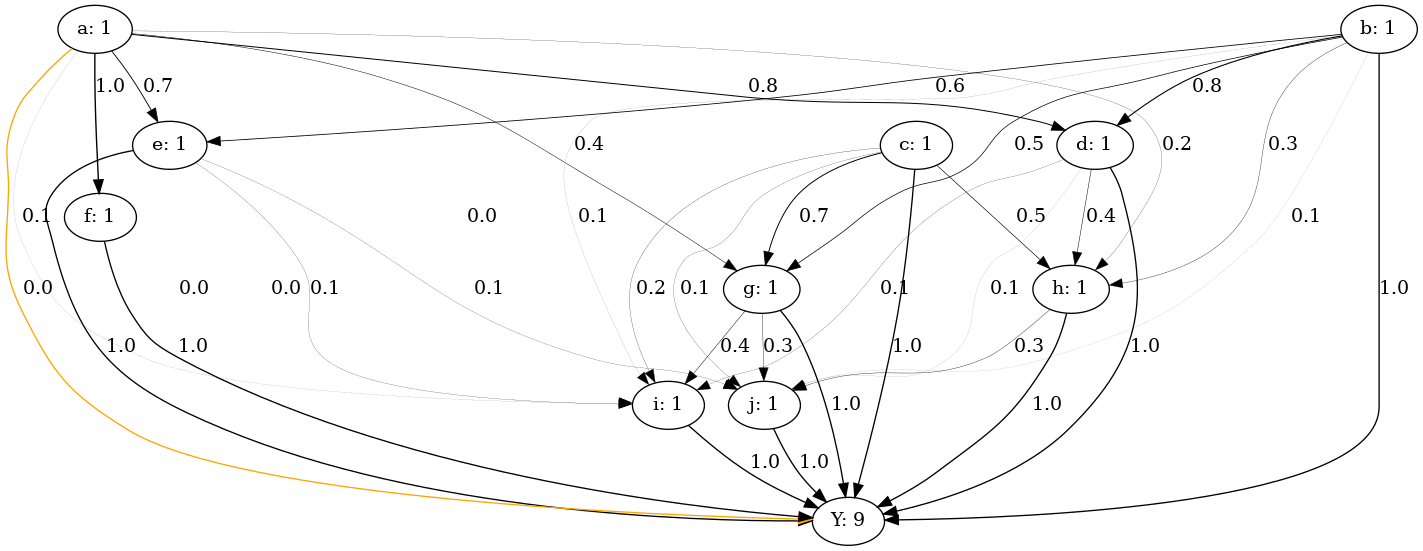

In [392]:
verbose = False
cf = CreditFlow(graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

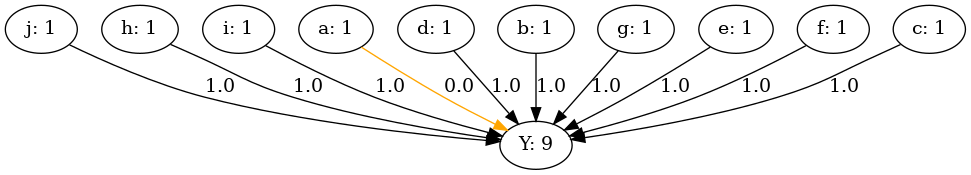

In [393]:
shap_graph = flatten_graph(graph)
verbose = False
cf = CreditFlow(shap_graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

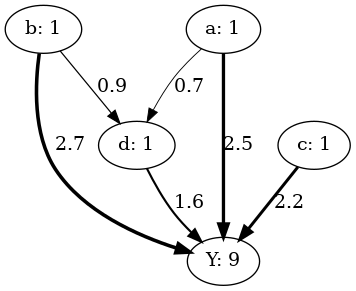

In [402]:
bgraph = boundary_graph(graph, ['a', 'b', 'c', 'd'])
verbose = False
cf = CreditFlow(bgraph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

Above we show explanation of a random system.

The first is Shapley flow, the second is Shap, and the third is some arbitrary boundary.

# Intervention simulation

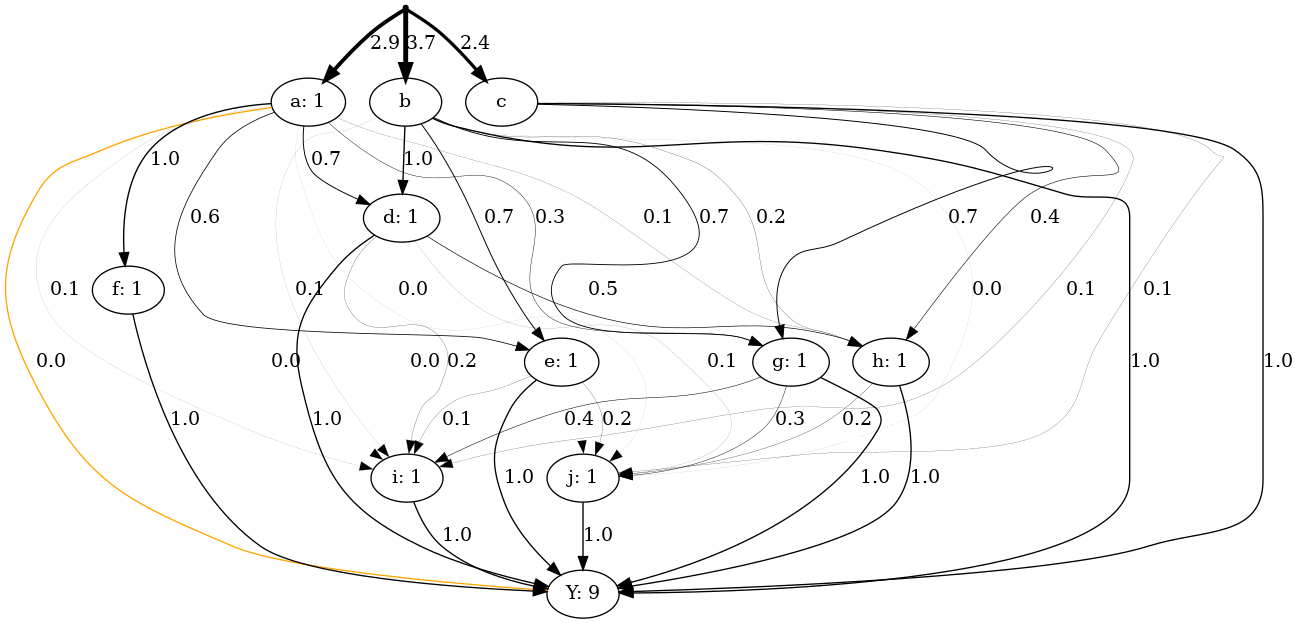

In [398]:
sgraph = single_source_graph(graph)
verbose = False
cf = CreditFlow(sgraph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

In [357]:
sources = get_source_nodes(graph)
d = dict((node.name, 0) for node in sources)
d.update({'d': 1})
print('output:', eval_graph(graph, d))

output: 1
